In [1]:
import os
from gpuutils import GpuUtils
GpuUtils.allocate(gpu_count=1, framework='keras')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True) 

GPU 2  will be allocated


2022-06-23 17:59:18.302527: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-23 17:59:18.337068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-06-23 17:59:18.337253: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-23 17:59:18.339259: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-23 17:59:18.340979: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-23 17:59:18.341261: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [2]:
#import sys
#sys.path.insert(0,'/home/halin/.local/lib')
from matplotlib import pyplot as plt
import numpy as np
#import seaborn as sns
import pandas as pd
from gc import callbacks
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, UpSampling1D
from keras_flops import get_flops
import Help_functions.creating_models as cm
import Help_functions.plot_functions as pf
import Help_functions.data_manage as dm
from Model_classes.NewPhysicsAutoencoder import NewPhysicsAutoencoder
from Model_classes.SecondCNNModel import SecondCNNModel
from Model_classes.DenseModel import DenseModel
from Model_classes.ConvAutoencoder import ConvAutoencoder



In [3]:
data_url = '/home/halin/Autoencoder/Data/'
x_test, y_test, smask_test, signal, noise, std, mean = dm.load_data(all_signals=True,
																																		 data_path=data_url, 
																																		 small_test_set=1000,
																																		 number_of_files=10)


In [4]:
BATCH_SIZE = 32
EPOCHS = 50
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)
]

In [16]:
model_cnn = Sequential()
model_cnn.add(Conv1D(5, 10, activation='relu', input_shape=(100, 1)))  # n_filters, n_width
model_cnn.add(Dropout(0.5))
model_cnn.add(MaxPooling1D(pool_size=10))
model_cnn.add(Flatten())  
model_cnn.add(Dense(1, activation='sigmoid'))
print(model_cnn.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 91, 5)             55        
_________________________________________________________________
dropout_3 (Dropout)          (None, 91, 5)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 9, 5)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 45)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 46        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
flops = get_flops(model_cnn)
print(f"number of floating point operations {flops:.3g}")
opt = keras.optimizers.Adam(learning_rate=0.0005)
model_cnn.compile(optimizer=opt,
          loss='binary_crossentropy',
          metrics=['accuracy'])

In [18]:
x_train = noise
x_train = np.expand_dims(x_train, axis=-1)

y_train = np.ones(len(x_train))


In [ ]:
model_cnn.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=callbacks_list,
          validation_split=0.2,
          verbose=1)

In [20]:
model_cnn = keras.models.load_model('best_model.h5')
# plot signal efficiency vs. noise rejection
y_pred = model_cnn.predict(x_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
smask = y_test == 1
_ = plt.hist(y_pred[smask], bins=10, alpha=0.5, label='Noise')
_ = plt.hist(y_pred[~smask], bins=10, alpha=0.5, label='Signal')
plt.legend()

In [26]:
print(np.min(y_pred))

0.99549353


In [27]:
min = np.min(y_pred)
max = np.max(y_pred)
yy = np.linspace(min, max, 1000)
n = np.zeros_like(yy)
s = np.zeros_like(yy)
len_pred_noise = len(y_pred[smask])
len_pred_signal = len(y_pred[~smask])
for iT, threshold in enumerate(yy):
    eff_signal = np.sum((y_pred[~smask] < threshold) == True) / len_pred_signal
    s[iT] = eff_signal
    eff_noise = np.sum((y_pred[smask] >= threshold) == True) / len_pred_noise
    if(eff_noise < 1):
        reduction_factor = 1 / (1 - eff_noise)
    else:
        reduction_factor = len(noise)
    n[iT] = reduction_factor


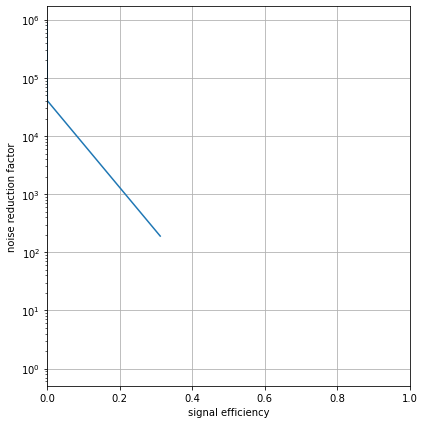

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(s, n)
ax.set_xlabel("signal efficiency")
ax.set_ylabel("noise reduction factor")
ax.semilogy(True)
ax.set_xlim(0,1)
ax.grid(1)
fig.tight_layout()
plt.show()